Simple TL-FWI Example
==================

In this section we see application of PyFWI for performing time-lapse FWI.
First, forward modeling is shown and then we estimate a model of subsurface using FWI.


 **1. Forward modeling**



In this simple example, we use PyFWI to do forward modeling. So, we need to first import the following packages amd modulus.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../src/')

import PyFWI.wave_propagation as wave
import PyFWI.acquisition as acq
import PyFWI.seiplot as splt
import PyFWI.model_dataset as md
import PyFWI.fwi_tools as tools
import PyFWI.processing as process
from PyFWI.tl_fwi import TimeLapse
import copy 



Baseline and monitor models can be created by using ```model_dataset``` module as

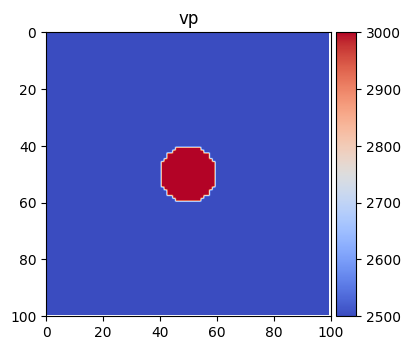

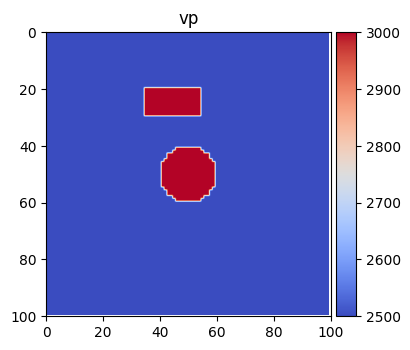

In [2]:
Model = md.ModelGenerator('louboutin')
bl = Model()
ml = copy.deepcopy(bl)
ml["vp"][20:30, 35:55] += 0.2 * ml["vp"][20:30, 35:55]

im = splt.earth_model(bl, ["vp"], cmap='coolwarm')
im = splt.earth_model(ml, ["vp"], cmap='coolwarm')


Then we need to create an input dictionary as follow

In [3]:
model_shape = ml[[*ml][0]].shape

inpa = {
    'ns': 4,  # Number of sources
    'sdo': 4,  # Order of FD
    'fdom': 15,  # Central frequency of source
    'dh': 7,  # Spatial sampling rate
    'dt': 0.004,  # Temporal sampling rate
    'acq_type': 0,  # Type of acquisition (0: crosswell, 1: surface, 2: both)
    't': 0.6,  # Length of operation
    'npml': 20,  # Number of PML 
    'pmlR': 1e-5,  # Coefficient for PML (No need to change)
    'pml_dir': 2,  # type of boundary layer
    # 'device': 1, # The device to run the program. Usually 0: CPU 1: GPU
}

seisout = 0 # Type of output 0: Pressure

inpa['rec_dis'] =  1 * inpa['dh']  # Define the receivers' distance


Now, we obtain the location of sources and receivers based on specified parameters.

In [4]:
offsetx = inpa['dh'] * model_shape[1]
depth = inpa['dh'] * model_shape[0]

src_loc, rec_loc, n_surface_rec, n_well_rec = acq.acq_parameters(inpa['ns'], 
                                                                 inpa['rec_dis'], 
                                                                 offsetx,
                                                                 depth,
                                                                 inpa['dh'], 
                                                                 inpa['sdo'], 
                                                                 acq_type=inpa['acq_type'])        
# src_loc[:, 1] -= 5 * inpa['dh']

# Create the source
src = acq.Source(src_loc, inpa['dh'], inpa['dt'])
src.Ricker(inpa['fdom'])


Finally, we can have the forward modelling as 

In [5]:
# Create the wave object
W = wave.WavePropagator(inpa, src, rec_loc, model_shape,
                        n_well_rec=n_well_rec,
                        components=seisout, chpr=0)

# Call the forward modelling 
db_obs = W.forward_modeling(bl, show=False)  # show=True can show the propagation of the wave

for baseline model and

In [6]:
# Create the wave object
W = wave.WavePropagator(inpa, src, rec_loc, model_shape,
                        n_well_rec=n_well_rec,
                        components=seisout, chpr=0)

# Call the forward modelling 
dm_obs = W.forward_modeling(ml, show=False)  # show=True can show the propagation of the wave

for monitor model.

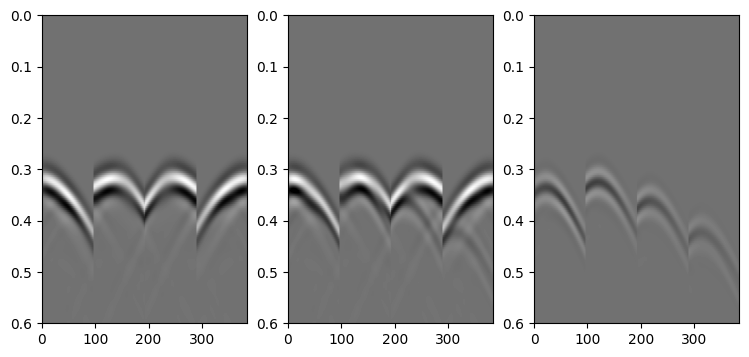

In [7]:
vmin, vmax = db_obs["taux"].min(), db_obs["taux"].max()

fig, ax = plt.subplots(1, 3, figsize=(9, 4))
ax[0].imshow(db_obs["taux"], cmap='gray', vmin=vmin, vmax=vmax,
           aspect="auto", extent=[0, dm_obs["taux"].shape[1], inpa['t'], 0])

ax[1].imshow(dm_obs["taux"], cmap='gray', vmin=vmin, vmax=vmax,
           aspect="auto", extent=[0, dm_obs["taux"].shape[1], inpa['t'], 0])

ax[2].imshow((dm_obs["taux"] - db_obs["taux"]), cmap='gray', vmin=vmin, vmax=vmax,
           aspect="auto", extent=[0, dm_obs["taux"].shape[1], inpa['t'], 0])

For performing TL-FWI, we need to pass both observed data through `process.prepare_residual(d_obs, gain_value)`.  This function is used to verify all components of the data and also to apply again (default value is 1).

In [8]:
db_obs = process.prepare_residual(db_obs)
dm_obs = process.prepare_residual(dm_obs)

**2. TL-FWI**

To perform TL-FWI, we need the observed data and an initial model. 

Here is a homogeneous initial model.

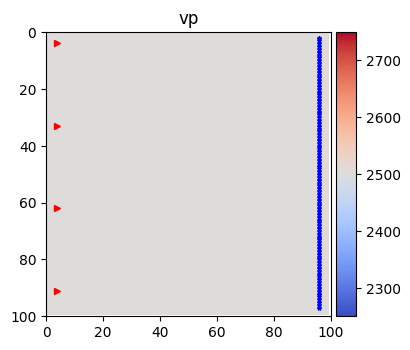

In [9]:
m0 = Model(smoothing=1)
m0['vs'] *= 0.0
m0['rho'] = np.ones_like(ml['rho'])

fig = splt.earth_model(m0, ['vp'], cmap='coolwarm')

fig.axes[0].plot(src_loc[:,0]//inpa["dh"], 
                 src_loc[:,1]//inpa["dh"], "r>", markersize=5)

fig.axes[0].plot(rec_loc[:,0]//inpa["dh"], 
                 rec_loc[:,1]//inpa["dh"], "b*", markersize=3)


Now, we can create a TL-FWI object,

In [10]:
tlfwi = TimeLapse(db_obs, dm_obs, inpa, src, rec_loc, model_shape, 
          components=seisout, chpr=20, n_well_rec=n_well_rec)


and call it by providing the initial model `m0`, TL-FWI method `tl_method`, desired frequencies for inversion, number of iterations for each frequency, number of parameters for inversion `n_params`, index of the first parameter `k_0`, and index of the last parameter `k_end`.

Let's call the TL-FWI object,


In [ ]:
m_est, _ = tlfwi(m0, tl_method="cc", 
                 freqs=[25, 45], iter=[2, 2], 
                 n_params=1, k_0=1, k_end=2)

Parameter number 1 to 1
2500.0 2500.0
 for f= 25: rms is: 0.00031876127468422055 with rms_reg: 0, and rms_data: 0.00031876127468422055, rms_mp: 0.0, rms_model_relation: 0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        10000     M =           10

At X0         0 variables are exactly at the bounds
Parameter number 1 to 1

At iterate    0    f=  3.18761D-04    |proj g|=  7.60487D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
10000      0      1      0     0     0   7.605D-10   3.188D-04
  F =   3.1876127468422055E-004

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

 This problem is unconstrained.


Here is the estimated model

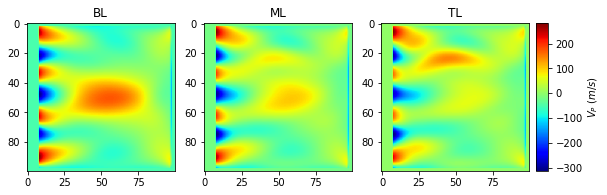

In [ ]:
# Time to plot the results
fig, ax = plt.subplots(1,3, figsize=(9, 4))
ax[0].imshow(m_est["b1"]["vp"], cmap='jet')
ax[0].set_title("BL")
ax[1].imshow(m_est["m1"]["vp"], cmap='jet')
ax[1].set_title("ML")
im = ax[2].imshow(m_est["dm"]["vp"], cmap='jet')
ax[2].set_title("TL")

points = ax[1].get_position().get_points()
dy = points[1, 1] - points[0, 1]
cax = fig.add_axes([0.91, points[0, 1], 0.02, dy])
cax.yaxis.set_ticks_position("right")
cbar = fig.colorbar(im, cax=cax, orientation="vertical", extend="neither", label="$V_P$ $(m/s)$")


Please note that this is a fast and simple implementation aiming to show how PyFWI can be used for a time-lapse study. Hence, the result is not accurate and better parameters and methods should be picked. For a review of different TL-FWI methods, I invite you to read [this paper](https://amirmardan.github.io/doc/wa_tlfwi.pdf).